The key aspect of ride-hailing is the price. It relies on technology to collect accurate tracking data so that a fair price can be calculated at the end of the trip. Fortunately, our riders are quick to tell us when they overpaid and we can use that feedback to improve our product.

Please analyze the dataset to identify top opportunities for reducing the number of overcharge tickets and present your results. Please provide us with a PDF file/document with the findings. Finally, you shouldn’t spend more than 8 hours on this analysis.

 Variables in the file:

order_id_new, order_try_id_new - id of an order

calc_created- time when the order was created

metered_price, distance, duration- actual price, distance and duration of a ride

upfront_price- promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)

distance - ride distance

duration - ride duration

gps_confidence- indicator for good GPS connection (1 - good one, 0 - bad one)

entered_by- who entered the address

b_state- state of a ride (finished implies that the ride was actually done)

dest_change_number- number of destination changes by a rider

predicted distance - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

predicted duration - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car

prediction_price_type- internal variable for the type of prediction:

upfront, prediction - prediction happened before the ride

upfront_destination_changed - prediction happened after rider changed destination during the ride

change_reason_pricing - records due to whose action the price changed

ticket_id_new - id for customer support ticket

https://drive.google.com/file/d/1ZNLnbwS3hnhjy3_6CYBcSu_72PCEcnVd/view?usp=sharing

In [245]:
! gdown --id 1ZNLnbwS3hnhjy3_6CYBcSu_72PCEcnVd

Downloading...
From: https://drive.google.com/uc?id=1ZNLnbwS3hnhjy3_6CYBcSu_72PCEcnVd
To: /content/Analytical_Task_2 (taxi startup).csv
100% 792k/792k [00:00<00:00, 81.1MB/s]


In [246]:
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostClassifier

In [247]:
df = pd.read_csv('Analytical_Task_2 (taxi startup).csv')

In [248]:
df.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [249]:
df.columns

Index(['order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score'],
      dtype='object')

In [250]:
df['overpaid_ride_ticket'].value_counts()

0    4606
1     337
Name: overpaid_ride_ticket, dtype: int64

In [251]:
df['calc_created'] = pd.to_datetime(df['calc_created'],format='%Y-%m-%d %H:%M:%S')

In [252]:
df['calc_created'].agg(['min','max'])

min   2020-02-02 00:01:16
max   2020-03-13 23:52:07
Name: calc_created, dtype: datetime64[ns]

In [253]:
df.isna().mean().sort_values()

order_id_new             0.000000
ticket_id_new            0.000000
order_try_state          0.000000
driver_app_version       0.000000
overpaid_ride_ticket     0.000000
driver_device_uid_new    0.000000
dest_change_number       0.000000
b_state                  0.000000
entered_by               0.000000
gps_confidence           0.000000
duration                 0.000000
distance                 0.000000
device_name              0.000000
eu_indicator             0.000000
calc_created             0.000000
order_try_id_new         0.000000
order_state              0.000000
rider_app_version        0.003237
predicted_distance       0.004046
predicted_duration       0.004046
prediction_price_type    0.004046
metered_price            0.004046
upfront_price            0.310338
fraud_score              0.558163
change_reason_pricing    0.939713
device_token             1.000000
dtype: float64

In [254]:
df = df[(~df['prediction_price_type'].isna())&(~df['rider_app_version'].isna())].copy()

In [255]:
df['dt_unix'] = df['calc_created'].astype(int) / 10**9

df.select_dtypes(include='object').columns

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


Index(['entered_by', 'b_state', 'prediction_price_type',
       'change_reason_pricing', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name'],
      dtype='object')

In [256]:
train = df.sample(frac=0.7,random_state=42).copy()
test = df[~df.index.isin(train.index)].copy()

len(train), len(test)

(3446, 1477)

In [257]:
X_col = ['order_id_new', 'order_try_id_new', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'fraud_score',
       'dt_unix']
y_col = ['overpaid_ride_ticket']

**using the CatBoost model, we will find the most significant features of the dataset**

In [258]:
cat_features = ['entered_by', 'b_state', 'prediction_price_type',
        'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'device_name']

model = CatBoostClassifier(learning_rate=0.005,
                           eval_metric='AUC',
                           cat_features=cat_features,verbose=100)

In [259]:
model.fit(train[X_col],train[y_col],
          eval_set=(test[X_col],test[y_col]))

0:	test: 0.8134606	best: 0.8134606 (0)	total: 14.3ms	remaining: 14.3s
100:	test: 0.8488624	best: 0.8488912 (93)	total: 933ms	remaining: 8.3s
200:	test: 0.8575905	best: 0.8575905 (200)	total: 1.83s	remaining: 7.28s
300:	test: 0.8634117	best: 0.8634261 (298)	total: 3.08s	remaining: 7.16s
400:	test: 0.8649407	best: 0.8654732 (378)	total: 4.25s	remaining: 6.34s
500:	test: 0.8648040	best: 0.8655811 (458)	total: 5.56s	remaining: 5.54s
600:	test: 0.8648616	best: 0.8655811 (458)	total: 6.98s	remaining: 4.63s
700:	test: 0.8644010	best: 0.8655811 (458)	total: 8.15s	remaining: 3.48s
800:	test: 0.8645593	best: 0.8655811 (458)	total: 9.32s	remaining: 2.31s
900:	test: 0.8644694	best: 0.8655811 (458)	total: 10.5s	remaining: 1.16s
999:	test: 0.8648220	best: 0.8655811 (458)	total: 11.8s	remaining: 0us

bestTest = 0.8655811075
bestIteration = 458

Shrink model to first 459 iterations.


In [260]:
model.predict_proba(test[X_col])

array([[0.98332747, 0.01667253],
       [0.83311298, 0.16688702],
       [0.93356112, 0.06643888],
       ...,
       [0.97939398, 0.02060602],
       [0.94535743, 0.05464257],
       [0.97954159, 0.02045841]])

In [261]:
fi = pd.DataFrame({'feature':X_col,'fi':model.feature_importances_})

In [262]:
fi.sort_values('fi',ascending=False)

,feature,fi
2,metered_price,13.985340
10,prediction_price_type,12.379858
21,eu_indicator,12.107867
22,fraud_score,8.901335
6,gps_confidence,7.448661
20,device_name,6.554602
5,duration,5.469510
3,upfront_price,5.262882
18,driver_app_version,4.596941
4,distance,4.086869


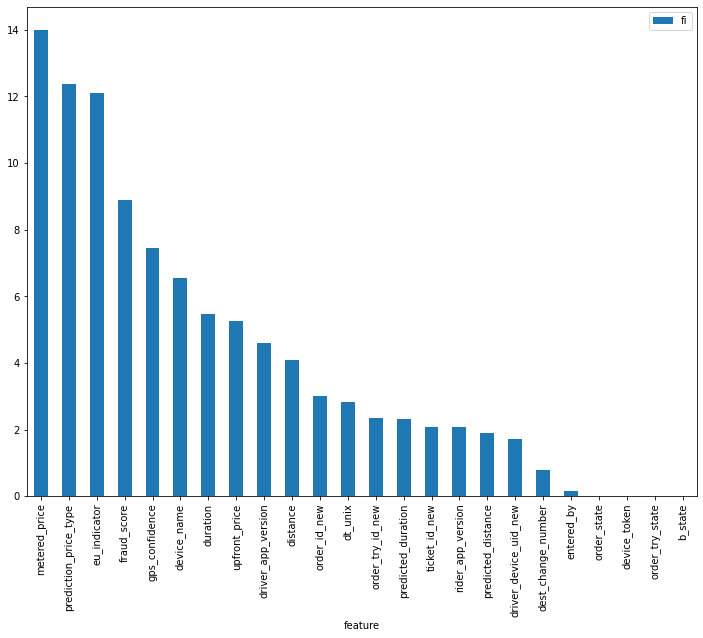

In [263]:
fi.sort_values('fi',ascending=False).set_index('feature').plot(kind='bar',figsize=(12,9))

**let's explore the top 5 significant features based on this histogram**

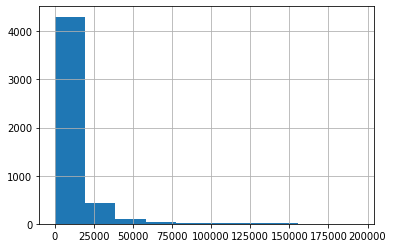

In [264]:
df['metered_price'].hist()

In [265]:
df['metered_price_bin'] = pd.qcut(df['metered_price'],5)

df.groupby('metered_price_bin')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
metered_price_bin,,
"(1.999, 4.72]",992,0.000000
"(4.72, 8.25]",978,0.005112
"(8.25, 6000.0]",1291,0.040279
"(6000.0, 13835.1]",677,0.138848
"(13835.1, 194483.52]",985,0.188832


the obvious conclusion: trips with a higher cost are more often overprice

In [266]:
df.groupby('prediction_price_type')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
prediction_price_type,,
prediction,1279,0.173573
upfront,3432,0.032634
upfront_destination_changed,208,0.014423
upfront_waypoint_changed,4,0.000000


the type of trips was more often predicted at the beginning

In [267]:
df.groupby('eu_indicator')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
eu_indicator,,
0,2173,0.149103
1,2750,0.004727


In [268]:
df['fraud_score'] = df['fraud_score'].fillna(-9999)

In [269]:
df['fraud_bin'] = pd.qcut(df['fraud_score'],5,duplicates='drop')

df.groupby('fraud_bin')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
fraud_bin,,
"(-14225.001, -9999.0]",2746,0.116533
"(-9999.0, -1821.6]",208,0.014423
"(-1821.6, -225.4]",984,0.008130
"(-225.4, 49.0]",985,0.006091


In [270]:
df.groupby('gps_confidence')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
gps_confidence,,
0,983,0.204476
1,3940,0.034518


another obvious remark: overprice trips could occur due to a **defective GPS**

In [271]:
df.groupby('device_name')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
device_name,,
Alps F9 Pro,10,0.000000
Alps NODROPOUT T25,1,0.000000
Alps TECNO B1p,1,0.000000
Asus ASUS_A002,5,0.000000
Asus ASUS_X00TD,3,0.000000
...,...,...
"iPhone8,1",89,0.011236
"iPhone8,2",18,0.000000
"iPhone8,4",35,0.000000


let's take a closer look at the driver's phone models

In [272]:
def device_cat(device_name):
  if 'tecno' in device_name.lower():
    return 'tecno'
  if 'iphone' in device_name.lower():
    return 'iphone'
  if 'lg' in device_name.lower():
    return 'lg'
  if 'samsung' in device_name.lower():
    return 'samsung'
  if 'htc' in device_name.lower():
    return 'htc'
  if 'nokia' in device_name.lower():
    return 'nokia'
  if 'xiaomi'in device_name.lower():
    return 'xiaomi'
  if 'HUAWEI'.lower() in device_name.lower():
    return 'HUAWEI'.lower()
  return 'misc'

In [273]:
df['device_group'] = df['device_name'].apply(device_cat)

In [274]:
df.groupby('device_group')['overpaid_ride_ticket'].agg(['count','mean']).sort_values('mean',ascending=False)

,count,mean
device_group,,
htc,16,0.312500
tecno,933,0.167203
nokia,158,0.113924
misc,700,0.095714
samsung,1675,0.038806
iphone,424,0.021226
huawei,720,0.019444
xiaomi,258,0.011628
lg,39,0.000000


**most likely, there is a problem with htc, tecno, nokia and misc phones**

In [275]:
df['dur_bin'] = pd.qcut(df['duration'],5)
df.groupby('dur_bin')['overpaid_ride_ticket'].agg(['count','mean'])

,count,mean
dur_bin,,
"(-0.001, 517.0]",987,0.033435
"(517.0, 864.0]",983,0.030519
"(864.0, 1305.0]",986,0.051724
"(1305.0, 2241.2]",982,0.105906
"(2241.2, 22402.0]",985,0.120812


the greater the distance of the trip - the greater the probability of an incorrect price determination

In [276]:
!pip install shap

In [277]:
import xgboost
import shap

shap.initjs()
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[X_col])
shap.force_plot(explainer.expected_value, shap_values[0,:], train[X_col].iloc[0,:])

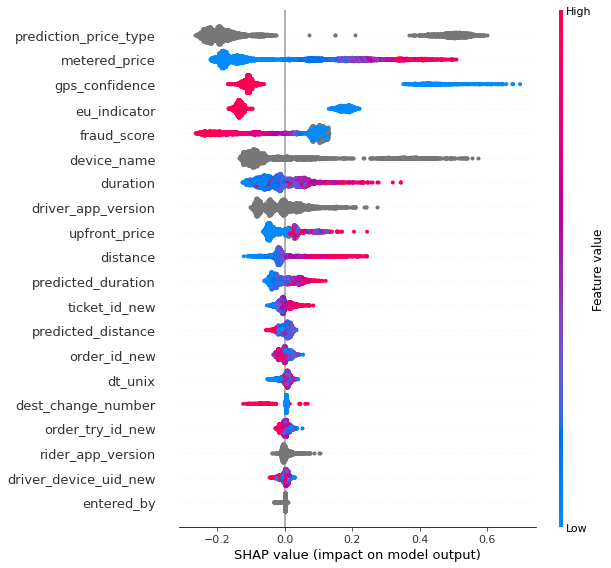

In [278]:
shap.summary_plot(shap_values, train[X_col])

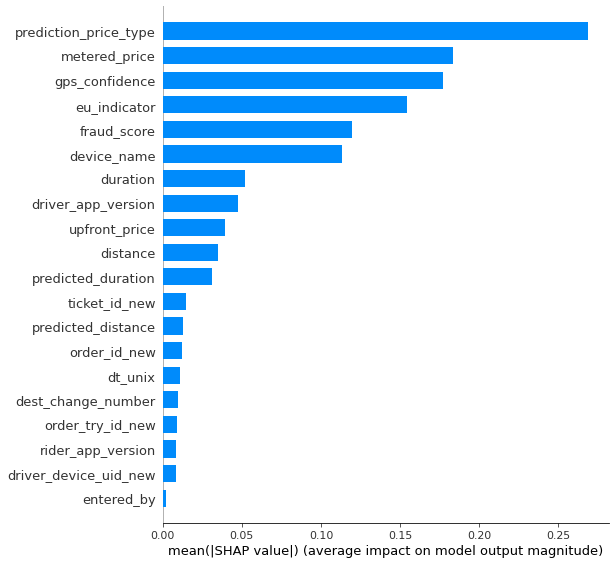

In [279]:
shap.summary_plot(shap_values, train[X_col], plot_type="bar")

we got the same result

In [280]:
[col for col in df.columns if 'price' in col]

['metered_price',
 'upfront_price',
 'prediction_price_type',
 'metered_price_bin']

In [281]:
df['distance_err'] = df['distance'] - df['predicted_distance']

In [282]:
df['duration_err'] = df['duration'] - df['predicted_duration']

In [283]:
df['distance_err_pct'] = np.abs(df['distance_err'])/(df['distance'])
df['duration_err_pct'] = np.abs(df['duration_err'])/df['duration']

In [284]:
df.replace([np.inf, -np.inf], np.nan)['distance_err_pct'].agg(['mean','median'])

mean      37.434295
median     0.163026
Name: distance_err_pct, dtype: float64

In [285]:
df.replace([np.inf, -np.inf], np.nan)['duration_err_pct'].agg(['mean','median'])

mean      3.195506
median    0.279104
Name: duration_err_pct, dtype: float64

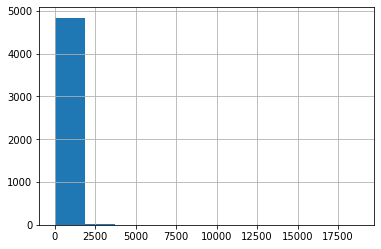

In [286]:
df.replace([np.inf, -np.inf], np.nan)['distance_err_pct'].hist()

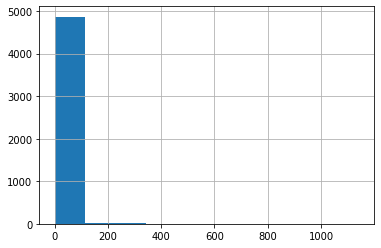

In [287]:
df.replace([np.inf, -np.inf], np.nan)['duration_err_pct'].hist()

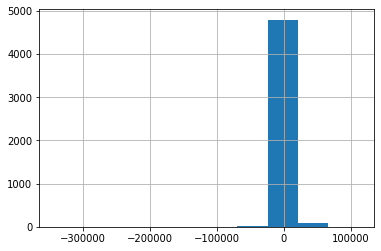

In [288]:
df.replace([np.inf, -np.inf], np.nan)['distance_err'].hist()

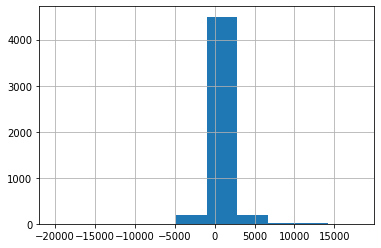

In [289]:
df.replace([np.inf, -np.inf], np.nan)['duration_err'].hist()

In [290]:
df['distance_err_bin'] = pd.qcut(df['distance_err'],5)

In [291]:
df.groupby('distance_err_bin')[['overpaid_ride_ticket','upfront_price','metered_price']].agg(['count','mean'])

overpaid_ride_ticket           upfront_price  \
                                     count      mean         count   
distance_err_bin                                                     
(-341860.001, -754.8]                  985  0.072081           622   
(-754.8, 0.0]                         1007  0.065541           693   
(0.0, 581.4]                           962  0.028067           784   
(581.4, 2466.0]                        984  0.033537           743   
(2466.0, 112012.0]                     985  0.142132           567   

                                   metered_price                
                              mean         count          mean  
distance_err_bin                                                
(-341860.001, -754.8]  9338.362058           985   6481.735442  
(-754.8, 0.0]          2072.340693          1007   5745.271192  
(0.0, 581.4]           1255.807270           962   3210.857422  
(581.4, 2466.0]        2696.943607           984   5552.151494  
(2466.0, 112012.0]     6964.358201           985  18938.390640

In [292]:
df['duration_err_bin'] = pd.qcut(df['duration_err'],5)

In [293]:
df.groupby('duration_err_bin')[['overpaid_ride_ticket','upfront_price','metered_price']].agg(['count','mean'])

overpaid_ride_ticket           upfront_price  \
                                    count      mean         count   
duration_err_bin                                                    
(-20081.001, -122.0]                  986  0.070994           729   
(-122.0, 34.0]                        988  0.033401           880   
(34.0, 257.0]                         982  0.027495           787   
(257.0, 845.0]                        983  0.090539           624   
(845.0, 18086.0]                      984  0.119919           389   

                                   metered_price                
                              mean         count          mean  
duration_err_bin                                                
(-20081.001, -122.0]   7674.807545           986   6989.042434  
(-122.0, 34.0]          780.946477           988   1707.660152  
(34.0, 257.0]          1541.834180           982   3134.069287  
(257.0, 845.0]         3527.216026           983   8091.943194  
(845.0, 18086.0]      11530.057841           984  20087.473496